In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping


In [2]:
#Загружаем данные и предобрабатываем их
data = pd.read_csv('dataset.csv', parse_dates=['course_finished_date'], index_col='course_finished_date')
target_variable = 'course_duration_sum'
feature_columns = ['ldap_unique_count', 'learning_unique_count', 'course_id_unique_count', 
                   'program_id_unique_count', 'ct_Article', 'ct_Exercise', 'ct_File', 
                   'ct_Interview', 'ct_Scorm', 'ct_Assessment', 'ct_Video', 'is_DebOcc', 
                   'is_academy', 'is_sage1_3', 'is_sage4_6', 'is_sage7_12', 'is_prof', 
                   'is_mo', 'is_plan', 'is_services', 'is_leadership', 'weekday', 'weekend','2_weeks_mean'] 


In [3]:
data = data[[target_variable] + feature_columns]

In [4]:
# Масштабируем данные
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [5]:
# Создаем обучающие и тестовые выборки
train_data, test_data = scaled_data[:365], scaled_data[365:-30]
# train_data, test_data = scaled_data[:-37], scaled_data[-47+8:-30] - для расчета на 7 дней

In [6]:
#  Преобразуем данные для LSTM
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), :-1])
        y.append(dataset[i + time_step, -1])
    return np.array(X), np.array(y)

In [7]:
time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [8]:
# Преобразуем данные для LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])


In [9]:
#Строим и обучаем модель LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Остановка обучения, если нет улучшений
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=13, validation_split=0.2, callbacks=[early_stopping] )

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1238 - val_loss: 0.0071
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - val_loss: 0.0097
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0165 - val_loss: 0.0060
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - val_loss: 0.0094
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - val_loss: 0.0052
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - val_loss: 0.0055
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0050
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0117 - val_loss: 0.0049
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - val_loss: 0.0048
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0144 - val_loss: 0.0047
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 - val_loss: 0.0085
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0

In [12]:
#  Прогнозируем значения на тестовой выборке
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


Инвертируем признаки обратно

In [13]:
def inverse_transform(predictions, scaler):
    # Создаем расширенный массив предсказаний, добавляя столбцы нулей
    extended_predictions = np.zeros((predictions.shape[0], scaler.n_features_in_))
    extended_predictions[:, 0] = predictions[:, 0]  # Целевая переменная в первом столбце
    # Применяем обратное масштабирование только к целевой переменной
    inverse_data = scaler.inverse_transform(extended_predictions)
    return inverse_data[:, 0]

In [14]:
train_predict = inverse_transform(train_predict, scaler)
y_train = inverse_transform(y_train.reshape(-1, 1), scaler)
test_predict = inverse_transform(test_predict, scaler)
y_test = inverse_transform(y_test.reshape(-1, 1), scaler)


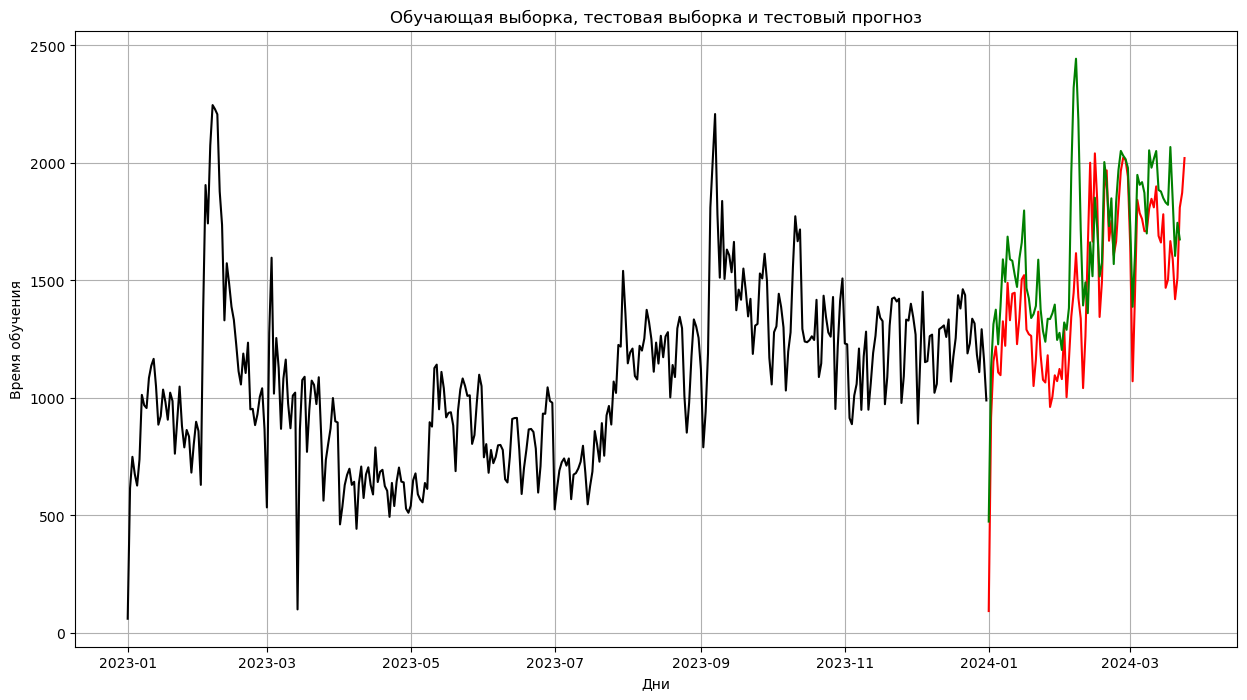

In [18]:
# Добавим дату в предикт
pred = test_predict
result_df = pd.DataFrame()
result_df["pred"] = pred
result_df.index = data.index[365:-30-2]

# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.figure(figsize=(15,8))
plt.plot(data[target_variable][:365], color = "black")
plt.plot(data[target_variable][365:-30], color = "red")
plt.plot(result_df, color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Время обучения')
plt.xlabel('Дни')
 
# добавим сетку
plt.grid()
 
plt.show()

In [16]:
# Оценка качества модели
mse = mean_squared_error(y_test, test_predict)
print('RMSE:', mse**0.5)

RMSE: 349.48287190170936
